# Classification Pneumonie

## Import

In [11]:
import os

import numpy as np
import pandas as pd 
import imageio
import random as rdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import scipy.ndimage as ndi

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import itertools  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score

## Define paths

In [2]:
dirname = 'chest_xray/'
train_path = os.path.join(dirname, 'chest_xray/train')
train_nrml_pth = os.path.join(train_path, 'NORMAL')
train_pnm_pth = os.path.join(train_path, 'PNEUMONIA')
test_path = os.path.join(dirname, 'chest_xray/test')
test_nrml_pth = os.path.join(test_path, 'NORMAL')
test_pnm_pth = os.path.join(test_path, 'PNEUMONIA')
val_path = os.path.join(dirname, 'chest_xray/val')
val_nrml_pth = os.path.join(val_path, 'NORMAL')
val_pnm_pth = os.path.join(val_path, 'PNEUMONIA')

## Plotting image

In [3]:
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        #print(img.shape)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

### Healthy people

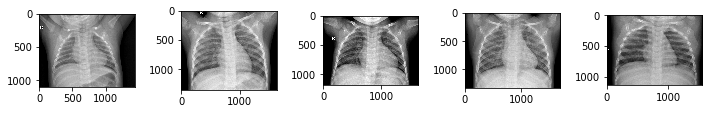

In [4]:
plot_imgs(train_nrml_pth, 5)

### People with pnemonia

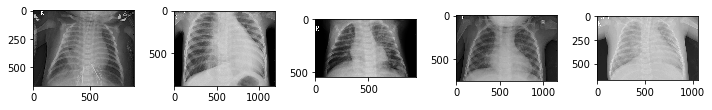

In [5]:
plot_imgs(train_pnm_pth, 5)

## Création du modèle

In [8]:
img_size_h = 300
img_size_w = 300

input_shape = (img_size_h, img_size_w, 1) 

In [9]:
model = Sequential([
    
    Conv2D(32, (3,3), input_shape=input_shape, padding = "same"),
    Activation('relu'),
    MaxPool2D((2, 2), padding = "same"),
    BatchNormalization(axis=1),
    
    Conv2D(32, (3,3)),
    Activation('relu'),
    MaxPool2D((2, 2), padding = "same"),
    BatchNormalization(axis=1),
    
    Conv2D(64, (3,3)),
    Activation('relu'),
    MaxPool2D((2, 2), padding = "same"),
    BatchNormalization(axis=1),
    
    Flatten(),
    
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
      
])

In [12]:
optimizer = Adam(lr = 0.0001)
model.compile(loss='binary_crossentropy', optimizer = optimizer , metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 300, 300, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      600       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
__________

## Data processing / Keras Data Generator

In [13]:
#augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#augmentation configuration we will use for validation / testing set
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [19]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    #subset='training',
    color_mode='grayscale',
    shuffle=True,
    seed = 1)

validation_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    #subset='validation',
    color_mode='grayscale',
    shuffle=True,
    seed = 1)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed = 1)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Hyperparamètres and Training

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)

early_stopping_monitor = EarlyStopping(patience = 4, monitor = "val_acc", mode="max", verbose = 2)

callback = [learning_rate_reduction, early_stopping_monitor]

In [21]:
history = model.fit_generator(
    train_generator,
    epochs = 10,
    validation_data=validation_generator,
    callbacks = callback,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_steps = validation_generator.samples // batch_size,
    )

Epoch 1/10
326/326 [==============================] - 1034s 3s/step - loss: 4.0879 - acc: 0.7421 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/10
326/326 [==============================] - 1015s 3s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/10
326/326 [==============================] - 1293s 4s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/10
326/326 [==============================] - 1181s 4s/step - loss: 4.0987 - acc: 0.7429 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 00004: early stopping


### Sauvegarde du modèle

In [24]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_modelV1') 

In [25]:
model = keras.models.load_model('saved_model/my_modelV1')

## Plots et prédiction

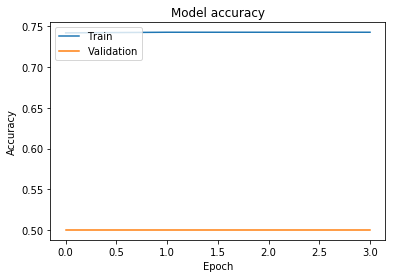

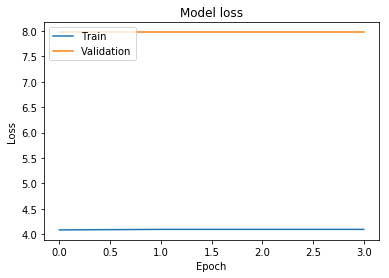

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
def get_datagenerator(generator):
    data_list = []
    data_class = []
    batch_index = 0

    while batch_index <= generator.batch_index:
        data = generator.next()
        data_list.append(data[0])
        data_class.append(data[1])
        batch_index = batch_index + 1

    # now, data_array is the numeric data of whole images
    train_data = np.concatenate(data_list)
    train_labels = np.concatenate(data_class)
    
    return train_data, train_labels

In [28]:
test_data, test_labels = get_datagenerator(test_generator)

# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size = batch_size)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 61s 99ms/step
Loss on test set:  5.978394471682035
Accuracy on test set:  0.625


In [29]:
# Get predictions
preds = model.predict(test_data, batch_size = batch_size)
preds = np.concatenate(preds)

In [30]:
precisions, recalls, thresholds = precision_recall_curve(test_labels, preds)
fpr, tpr, thresholds2 = roc_curve(test_labels, preds)

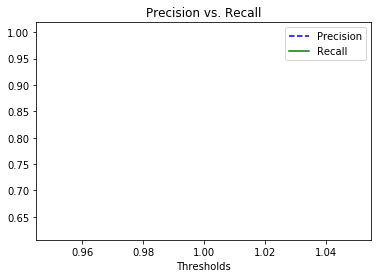

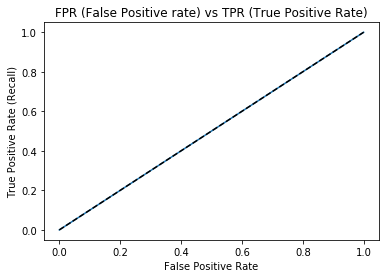

In [31]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [32]:
# Plot non-normalized confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  0 234]
 [  0 390]]
Normalized confusion matrix
[[ nan  inf]
 [0.   0.62]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


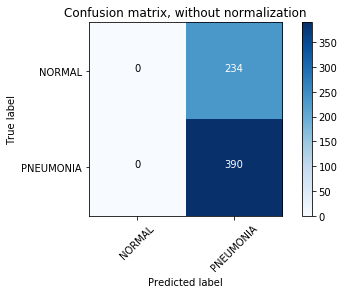

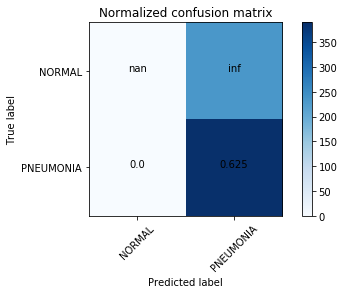

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = test_generator.class_indices.keys()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Test du modèle sur quelques exemples

In [34]:
def predict_illness(image_path):
    imge = plt.imread(image_path)
    plt.figure()

    img = image.load_img(image_path, target_size=(img_size_h, img_size_w), grayscale = "True")
    x = image.img_to_array(img) 
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict_classes(images, batch_size=10)
    if classes[0][0] == 0:
        textstr = "Prediction: Healthy"
    else:
        textstr = "Prediction: Pneumonia"

    if ('chest_xray/chest_xray/test/NORMAL' in image_path):
        texttruth = "Truth: Healthy"
    else :
        texttruth = "Truth: Pneumonia"
        
    plt.gcf().text(0.9, 0.4, textstr, fontsize=20)
    plt.gcf().text(0.9, 0.6, texttruth, fontsize=20)
    plt.imshow(img, cmap='gray')

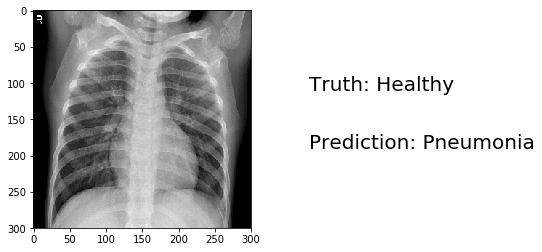

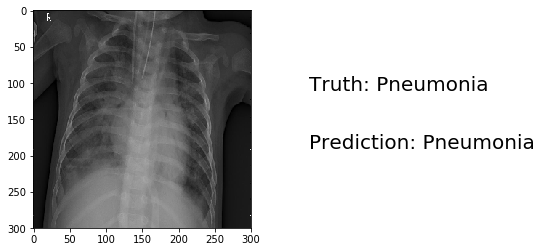

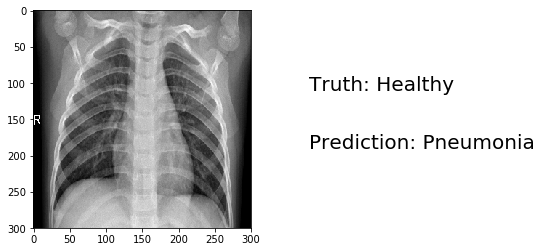

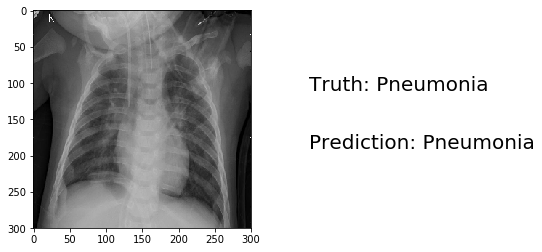

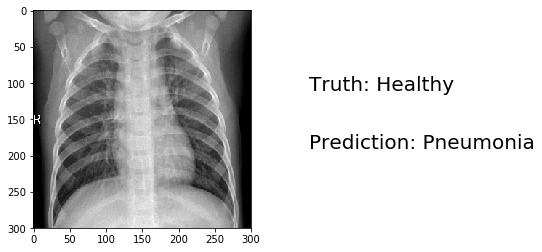

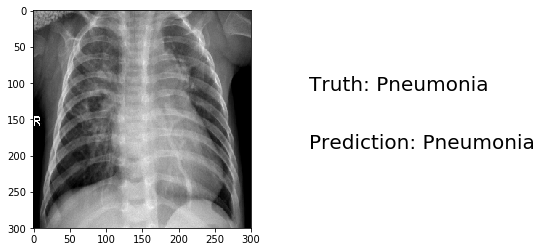

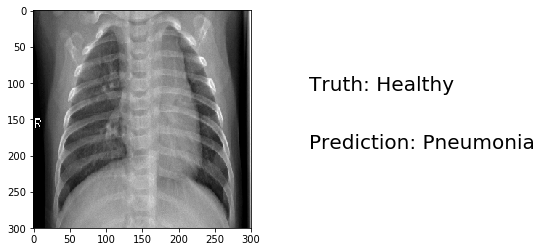

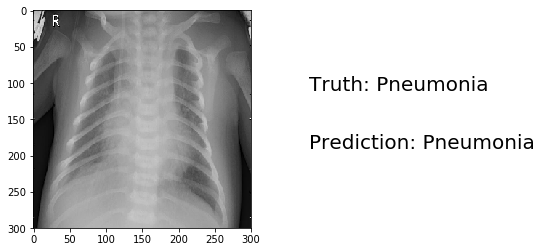

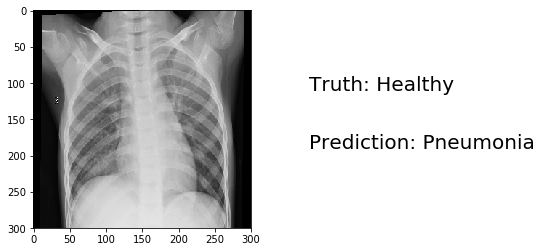

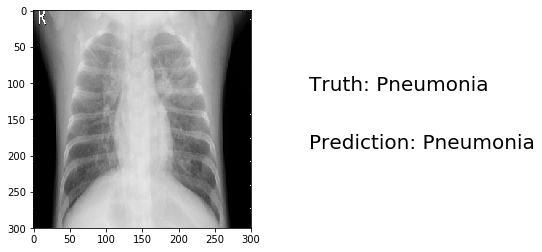

In [35]:
k = 5
sampling_normal = rdm.sample(os.listdir(test_nrml_pth), k=k)
sampling_pnm = rdm.sample(os.listdir(test_pnm_pth), k=k)

for i in range(0,k):
    
    img_test_nrml = os.path.join(test_nrml_pth, sampling_normal[i])
    img_test_ill = os.path.join(test_pnm_pth, sampling_pnm[i])
    
    imge = predict_illness(img_test_nrml)
    imge = predict_illness(img_test_ill)